In [12]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier 

In [13]:
data = pd.read_csv("/home/ivana/Desktop/IP-projekat/2023_Data_Mining_Smoking_Dataset/datasets/data1.csv")
data.columns

Index(['Unnamed: 0', 'gender', 'age', 'height(cm)', 'weight(kg)',
       'eyesight(left)', 'hearing(left)', 'hearing(right)', 'relaxation',
       'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL',
       'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'Gtp',
       'dental caries', 'tartar', 'smoking'],
      dtype='object')

In [14]:
data.drop('Unnamed: 0', axis=1,inplace=True)

In [15]:
data.shape

(55692, 20)

In [16]:
Y = data['smoking']
X = data.drop('smoking', axis=1)
feature_names = X.columns
X.head()

,gender,age,height(cm),weight(kg),eyesight(left),hearing(left),hearing(right),relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,hemoglobin,Urine protein,serum creatinine,AST,Gtp,dental caries,tartar
0,0,40,155,60,1.2,1.0,1.0,73.0,94.0,215.0,82.0,73.0,12.9,1.0,0.7,18.0,27.0,0,1
1,0,40,160,60,0.8,1.0,1.0,70.0,130.0,192.0,115.0,42.0,12.7,1.0,0.6,22.0,18.0,0,1
2,1,55,170,60,0.8,1.0,1.0,86.0,89.0,242.0,182.0,55.0,15.8,1.0,1.0,21.0,22.0,0,0
3,1,40,165,70,1.5,1.0,1.0,60.0,96.0,322.0,254.0,45.0,14.7,1.0,1.0,19.0,18.0,0,1
4,0,40,155,60,1.0,1.0,1.0,74.0,80.0,184.0,74.0,62.0,12.5,1.0,0.6,16.0,22.0,0,0


Meni vise smetaju ekstremni autlajeri na +-3IQR. Vidimo da atribut dental caries ima 21% autlajera. U ostalim atributima procenat autlajera je jako mali ili ih uopste nema.

In [17]:
def IQR(data, feature_names):
    
    iqr = pd.DataFrame(0, index=feature_names, columns=['lower', 'min', 'num_lower', 'upper', 'max', 'num_upper', 'percantage'])
    for name in feature_names:

        (Q1, Q3) = X[name].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        upper = Q3 + (3 * IQR)
        lower = Q1 - (3 * IQR)
        
        iqr.loc[name, 'upper'] = upper
        iqr.loc[name, 'lower'] = lower

        num_of_out_lower = (X[name] < lower).sum()
        num_of_out_upper = (X[name] > upper).sum()

        percentage = round((num_of_out_lower + num_of_out_upper) / X.shape[0] * 100)

        iqr.loc[name, 'num_lower'], iqr.loc[name, 'num_upper'], iqr.loc[name, 'percantage']  = num_of_out_lower, num_of_out_upper, percentage
        iqr.loc[name, 'min'], iqr.loc[name, 'max'] = min(X[name]), max(X[name])    
    return iqr

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, stratify=Y, random_state=12)

Nakon podele na test i trening skup radimo detekciju elemenata van granica inace bismo kompromitovali test skup.

In [19]:
iqr= IQR(X_train, feature_names)
print(iqr)

                     lower    min  num_lower  upper     max  num_upper  \
gender                -3.0    0.0          0    4.0     1.0          0   
age                   -5.0   20.0          0  100.0    85.0          0   
height(cm)           130.0  130.0          0  200.0   190.0          0   
weight(kg)            -5.0   30.0          0  135.0   135.0          0   
eyesight(left)        -0.4    0.1          0    2.4     9.9         92   
hearing(left)          1.0    1.0          0    1.0     2.0       1425   
hearing(right)         1.0    1.0          0    1.0     2.0       1456   
relaxation            34.0   40.0          0  118.0   146.0         55   
fasting blood sugar   44.0   46.0          0  149.0   505.0       1410   
Cholesterol           28.0   55.0          0  364.0   445.0         24   
triglyceride        -184.0    8.0          0  418.0   999.0          6   
HDL                  -10.0    4.0          0  123.0   618.0         46   
hemoglobin             7.0    4.9     

Kako je broj autlajera mali mozemo ih ostaviti.

Normalizacija:

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit_transform(X_train)


array([[-0.77367328,  0.22450401,  0.5449917 ,  0.04192824, -0.10993591,
         0.14460416],
       [-0.51178699,  0.01842673, -0.38376473, -0.21245397,  0.24315374,
        -0.18092468],
       [ 0.08759039, -0.72097173, -0.0608838 , -0.02063598, -0.0562659 ,
         0.15395195],
       ...,
       [ 0.87255479, -0.00334426,  0.06365922, -0.13725589,  0.0675163 ,
         0.09758968],
       [-0.51879937,  0.01127546, -0.38731518, -0.16305507,  0.15463885,
         0.02967088],
       [-0.85036041,  0.16774364,  0.54405957, -0.14744607,  0.14219352,
         0.07950059]])

In [22]:
pca.components_.shape

(6, 19)

In [23]:
pca_names = [f'Principal_component_{i}' for i in range(pca.n_components_)]

In [24]:
for i, component in enumerate(pca.components_):
    print(f'{pca_names[i]} = ', end='')
    print(' + '.join(f'{coef:.2f}*{feature_name}'
                     for coef, feature_name in zip(component, feature_names)))
    print('-'*80)


Principal_component_0 = -0.68*gender + 0.12*age + -0.19*height(cm) + -0.11*weight(kg) + -0.01*eyesight(left) + 0.01*hearing(left) + 0.01*hearing(right) + -0.03*relaxation + -0.01*fasting blood sugar + 0.01*Cholesterol + -0.05*triglyceride + 0.01*HDL + -0.10*hemoglobin + -0.00*Urine protein + -0.01*serum creatinine + -0.00*AST + -0.02*Gtp + -0.30*dental caries + -0.60*tartar
--------------------------------------------------------------------------------
Principal_component_1 = -0.63*gender + 0.06*age + -0.17*height(cm) + -0.10*weight(kg) + -0.01*eyesight(left) + -0.01*hearing(left) + -0.00*hearing(right) + -0.02*relaxation + -0.01*fasting blood sugar + 0.01*Cholesterol + -0.04*triglyceride + 0.01*HDL + -0.09*hemoglobin + -0.00*Urine protein + -0.01*serum creatinine + -0.00*AST + -0.01*Gtp + 0.18*dental caries + 0.72*tartar
--------------------------------------------------------------------------------
Principal_component_2 = -0.11*gender + -0.02*age + -0.03*height(cm) + -0.01*weight(k

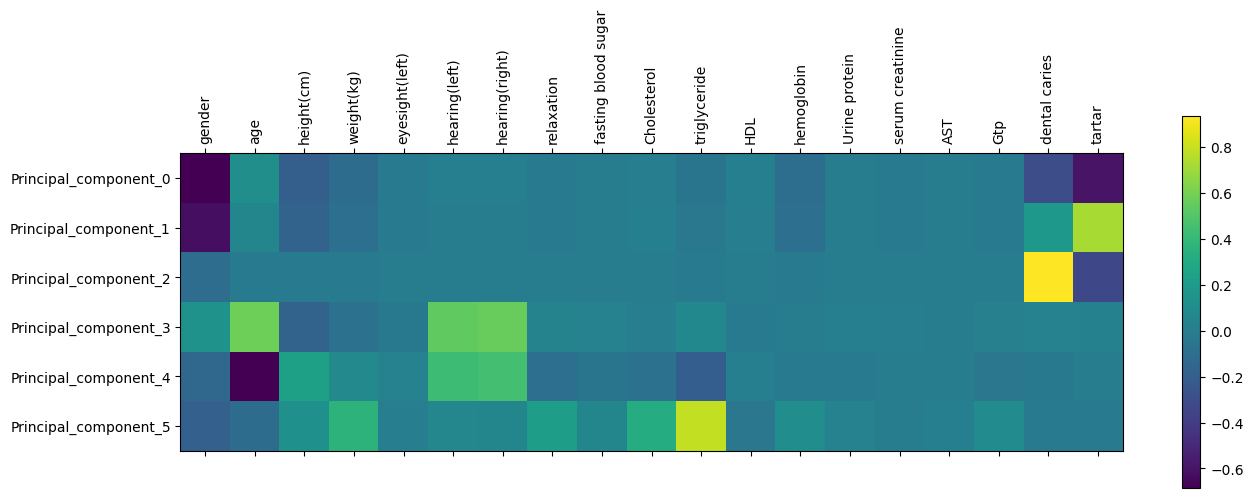

In [25]:
from matplotlib import pyplot as plt

plt.matshow(pca.components_)
plt.xticks(ticks=range(pca.components_.shape[1]),
           labels=feature_names,
           rotation='vertical')
plt.yticks(ticks=range(pca.n_components_),
           labels=pca_names)
plt.colorbar()
plt.show()

In [26]:
pca.explained_variance_

array([0.28457846, 0.24147741, 0.15353099, 0.0447913 , 0.02740336,
       0.01987177])

In [27]:
pca.explained_variance_ratio_

array([0.34095726, 0.28931732, 0.18394753, 0.05366505, 0.03283233,
       0.02380863])

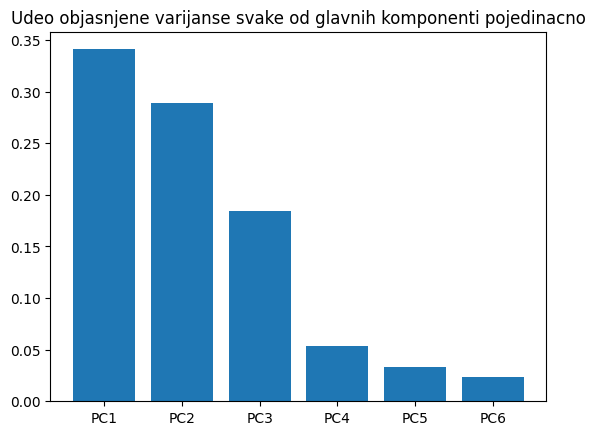

In [28]:
plt.bar(x=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'],
        height=pca.explained_variance_ratio_)
plt.title('Udeo objasnjene varijanse svake od glavnih komponenti pojedinacno')
plt.show()

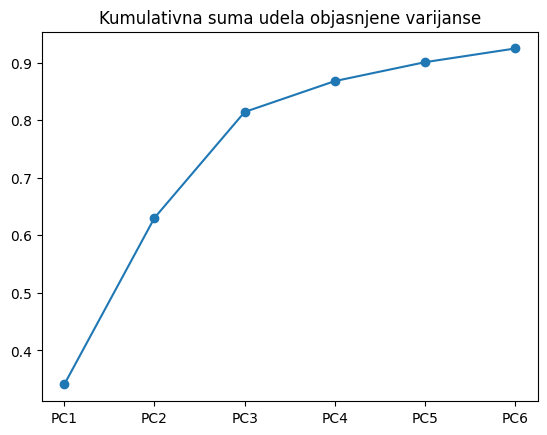

In [29]:
import numpy as np

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.plot(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], cumulative_variance_ratio, marker='o')
plt.title('Kumulativna suma udela objasnjene varijanse')
plt.show()

Mozemo primetiti da prvih sest glavnih komponenti objasnjavaju ukupno vise od 90% ukupne varijanse podataka.

In [30]:
from sklearn.metrics import classification_report
from termcolor import colored

def report(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Izvestaj o klasifikaciji za model{} nad {} podacima".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report(y, y_pred))
    print("---------------------------------------------------------------------------------")
    
    print(colored("Matrica konfuzije za model {} nad {} podacima ".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred), columns=['1', '0'], index=['1', '0']))
    print("---------------------------------------------------------------------------------")
    


Treniramo model:

In [31]:
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train) # treninranje modela

KNeighborsClassifier()

In [32]:
report(knn, X_train, Y_train)

Izvestaj o klasifikaciji za modelKNeighborsClassifier nad training podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     24666
           1       0.76      0.75      0.76     14318

    accuracy                           0.82     38984
   macro avg       0.81      0.81      0.81     38984
weighted avg       0.82      0.82      0.82     38984

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad training podacima 
---------------------------------------------------------------------------------
       1      0
1  21287   3379
0   3522  10796
---------------------------------------------------------------------------------


Vidimo da je f1-score nad trening skupom 80.05%, dok je  nad test skupom 71.5%.

In [33]:
report(knn, X_test, Y_test, "test")

Izvestaj o klasifikaciji za modelKNeighborsClassifier nad test podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.79      0.79     10571
           1       0.64      0.64      0.64      6137

    accuracy                           0.74     16708
   macro avg       0.72      0.71      0.71     16708
weighted avg       0.73      0.74      0.73     16708

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad test podacima 
---------------------------------------------------------------------------------
      1     0
1  8385  2186
0  2238  3899
---------------------------------------------------------------------------------


# Podesavanje hiper-parametara

In [34]:
import math
math.ceil(math.sqrt(X_train.shape[0]))

198

In [35]:
from sklearn.model_selection import GridSearchCV
params={
    'n_neighbors':[70,160,180], 
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

In [36]:
knn_cv = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=5, scoring= 'f1')
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [70, 160, 180], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [38]:
knn_cv.best_params_

{'n_neighbors': 160, 'p': 1, 'weights': 'distance'}

In [39]:
knn_cv.best_score_

0.7360601934473119

In [41]:
report(knn_cv.best_estimator_, X_train, Y_train)

Izvestaj o klasifikaciji za modelKNeighborsClassifier nad training podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24666
           1       1.00      1.00      1.00     14318

    accuracy                           1.00     38984
   macro avg       1.00      1.00      1.00     38984
weighted avg       1.00      1.00      1.00     38984

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad training podacima 
---------------------------------------------------------------------------------
       1      0
1  24666      0
0      0  14318
---------------------------------------------------------------------------------


Iako se cini da do njega dolazi, to nije slucaj. Posto je za najbolji model izabran parametar weight='distance', dakle udaljenost suseda od instance utice na klasifikaciju (sto je sused blizi instanci koju klasifikujemo, njegov "glas" ima vecu tezinu). Kada evaluiramo model nad trening skupom, sve instance za koje trazimo susede, imaju suseda na rastojanju 0 (to su one same) i onda njihova klasa uvek u potpunost odredjuje klasu instance koju klasifikujemo.(Intuitivno, ako je weights='distance' i u skupu za trening postoji identicna instanca onoj koju klasifikujemo, onda ce novoj instanci biti dodeljena ista klasa). A kada pokusamo sa evaluacijom na test skupu, sada instance koje klasifikujemo nemaju susede na razdaljini 0, pa mnogo vise suseda utice na klasifikaciju (pa je i tacnost manja). 

In [43]:
report(knn_cv.best_estimator_, X_test, Y_test, "test")

Izvestaj o klasifikaciji za modelKNeighborsClassifier nad test podacima
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     10571
           1       0.74      0.78      0.76      6137

    accuracy                           0.82     16708
   macro avg       0.80      0.81      0.80     16708
weighted avg       0.82      0.82      0.82     16708

---------------------------------------------------------------------------------
Matrica konfuzije za model KNeighborsClassifier nad test podacima 
---------------------------------------------------------------------------------
      1     0
1  8861  1710
0  1361  4776
---------------------------------------------------------------------------------


Vidimo da je f1 score na test skupu 80.5%.

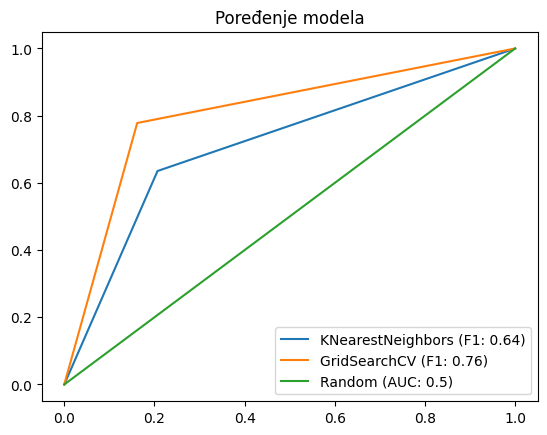

In [45]:
from sklearn.metrics import f1_score, roc_curve, roc_auc_score

models = [knn, knn_cv.best_estimator_]
model_names = ['KNearestNeighbors', 'GridSearchCV']

for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)  # Dodajemo izračunavanje F1-score
    lab = model_name + " (F1: " + str(round(f1, 2)) + ")"  # Prikazujemo F1-score umesto AUC
    plt.plot(fpr, tpr, label=lab)

plt.plot([0, 1], [0, 1], label='Random (AUC: 0.5)')  # Prikazujemo isti random krivu, iako koristimo F1-score
plt.title("Poređenje modela")
plt.legend()
plt.show()


Poredjenjem modela zakljucujemo da je bolje rezultate daje model sa podesenim parametrima.

In [46]:
from joblib import dump
dump(models, 'knn.joblib')

['knn.joblib']